# Calculating sensitivities to the survey design

**Research setting: hot water is injected into a shallow aquifer at the HT-ATES site in Delft. We investigate the use of a surface-to-borehole CSEM monitoring set-up for recovering the shape of the hot plume that develops.**

**This code is based on the Emg3d example code: https://emsig.xyz/emg3d-gallery/gallery/tutorials/gradient.html#sphx-glr-gallery-tutorials-gradient-py**

In Emg3d it is possible to calculate the sensitivity gradient for a particular survey design. For this it's necessary to use the Simulation class, which contains the survey parameters, the subsurface model, and gridding options.

To retrieve the gradient for synthetic data we use the Simulation class twice:
- A first Simulation is created to generate the synthetic data including the desired noise parameters (using Simulation.compute).
- A second Simulation instance is then created that includes this synthetic data *as observed data stored in the associated survey* while the 'model' parameter of the Simulation itself is set to be the desired starting model.
- Each of the Simulation instances needs its own Survey class as this is where the data is stored.
- (Note that all Surveys and Simulations need to have their own name in order for it to work.)

Information on how the gradient is calculated: https://emg3d.emsig.xyz/en/stable/api/emg3d.simulations.Simulation.html#emg3d.simulations.Simulation.gradient

## In this version

We test what the gradient looks like using the following synthetic data & starting model combinations:
- A 1d baseline layered structure w/ homogeneous halfspace starting model
- A 3d image of the hot plume as perturbation of the layered structure w/ layered structure starting model
- The baseline layered structure synthetic data w/ baseline layered structure starting model (to test the effect of noise)

Parameters used:
- Using a single source
- Receivers in the borehole with 15 m spacing
- Grid spacing in the z-direction of 5 m
- 1% relative noise (dominant) and a 1e-15 noise floor
- A layered baseline model based on early interpretations of borehole logs and drilling reports
- A hot plume model generated in COMSOL using the model developed by Gao et al. in 2024 paper
- A uniform 25 Ohmm starting model (here called iso for isotropic, but what is meant is a homogeneous halfspace model)

**Conclusion of this notebook: The gradient of the target synthetic data w/ baseline starting model looks very similar to that of the baseline synthetic data (baseline + noise) w/ baseline starting model. This could be because of the limited amount of sources and receivers, and a low signal/noise ratio.**

## To be updated
- Hot plume is too cropped
- More receivers are needed to be sensitive to the hot plume
- A difference in the air layer can be seen - is this important?

In [2]:
import emg3d
import empymod
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, SymLogNorm, Normalize
import matplotlib.cm
import time

plt.style.use('bmh')

# Comment this out on Google Colab
#%matplotlib widget

# Create survey and grid

In [3]:
# Create a survey

# Acquisition source frequencies (Hz)
frequencies = [1.0]

# Source coordinates, a horizontal y-directed point dipole
src_x = 0
src_y = -126
src_z = 0
src = emg3d.surveys.txrx_coordinates_to_dict(
        emg3d.TxElectricDipole,
        (src_x, src_y, src_z, 90.0, 0.0)
)

# Receiver positions, vertical z-directed point dipoles
rec_x = np.arange(1, 21)*0
rec_y = np.array([74]*20)
rec_z = np.arange(1,21)*-15
rec = emg3d.surveys.txrx_coordinates_to_dict(
        emg3d.RxElectricPoint,
        (rec_x, rec_y, rec_z, 0.0, 90.0)
)

In [131]:
survey = emg3d.surveys.Survey(
    name='Example survey, not used',  # Name of the survey
    sources=src,               # Source coordinates
    receivers=rec,             # Receiver coordinates
    frequencies=frequencies,   # Two frequencies
    # data=data,               # If you have observed data
    noise_floor=1e-15,
    relative_error=0.01,
)

# Let's have a look at the survey:
survey

:: Survey «Example survey, not used» ::

<xarray.Dataset> Size: 916B
Dimensions:   (src: 1, rec: 20, freq: 1)
Coordinates:
  * src       (src) <U6 24B 'TxED-1'
  * rec       (rec) <U7 560B 'RxEP-01' 'RxEP-02' ... 'RxEP-19' 'RxEP-20'
  * freq      (freq) <U3 12B 'f-1'
Data variables:
    observed  (src, rec, freq) complex128 320B (nan+nanj) ... (nan+nanj)
Attributes:
    noise_floor:     1e-15
    relative_error:  0.01

In [132]:
grid = emg3d.construct_mesh(
    center=(0,0,0),                                 # Center of wanted grid
    frequency=frequencies[0],                            # Frequency we will use the grid for
    properties=[25, 25, 1e8],                       # Reference resistivity
    domain=([-150, 150], [-300, 300], [-250, 0]),   # Domain in which we want precise results
    center_on_edge=True,
    min_width_limits = [10, 10, 5],
)
 
grid  # mesh info
#grid.plot_grid() # plotting the grid

TensorMesh: 983,040 cells

                      MESH EXTENT             CELL WIDTH      FACTOR
  dir    nC        min           max         min       max      max
  ---   ---  ---------------------------  ------------------  ------
   x     80   -103,135.26    103,135.26     10.00 28,028.05    1.37
   y    128   -105,016.88    105,016.88     10.00 21,122.27    1.25
   z     96    -18,829.13    107,047.88      5.00 31,622.65    1.42

# Fill in resistivities

## Isotropic model

In [16]:
#Only air interface is included
depth = [0]

# Layer resistivities in Ohm.m
resistivities_iso = np.array([1e8, 25.0]) # base incl. air (lower res, because of 3D modelling)

# Pre-allocate an array with number of cells corresponding to our grid
res = np.ones(grid.shape_cells)

# Layered base model: Fill in layered resistivities into our grid
dd = np.r_[np.inf, depth, -np.inf]
for i in range(len(resistivities_iso)):
    res[:, :, (grid.cell_centers_z > dd[i+1]) & (grid.cell_centers_z <= dd[i])] = resistivities_iso[i]

# Create the homogenous 25 kOhm model
model_iso = emg3d.Model(grid, property_x=res, mapping='Resistivity')

## Baseline model

In [24]:
# We idealize the depth model here a bit, to have cells of 10m in depth
depth = [0, -50, -80, -120, -190]

# Layer resistivities in Ohm.m
resistivities_base = np.array([1e8, 52.0, 38.0, 26.0, 29.5, 17.5]) # base incl. air (lower res, because of 3D modelling)

# Pre-allocate an array with number of cells corresponding to our grid
res = np.ones(grid.shape_cells)

# Layered base model: Fill in layered resistivities into our grid
dd = np.r_[np.inf, depth, -np.inf]
for i in range(len(resistivities_base)):
    res[:, :, (grid.cell_centers_z > dd[i+1]) & (grid.cell_centers_z <= dd[i])] = resistivities_base[i]

# Create the layered base model
model_base = emg3d.Model(grid, property_x=res, mapping='Resistivity')

## Target model - round hot plume (Not used)
Next iteration: test the gradient of the buoyant hot plume against the round hot plume

In [9]:
#Hot plume parameters
res_target = 13.1
radius = 80

#Flatten baseline resistivities for editing
res2 = res.ravel('F')

#Generate boolean arrays wich describe a cube where the hot plume will be
xx = abs(grid.cell_centers[:,0]) <= radius
yy = abs(grid.cell_centers[:,1]) <= radius
zz = (grid.cell_centers[:,2] > depth[-1]) & (grid.cell_centers[:,2] <= depth[-2])
cube = xx*yy*zz #indeces describing the cube for a flattened res. array

#Now refine to create a circle, first eliminating the points already excluded
plume = []
cell_nr = len(xx)
for i in np.arange(cell_nr):
    if cube[i] == False:
        plume.append(False)
    else:
        plume.append(abs(grid.cell_centers[i,1]) <= np.sqrt(radius**2-grid.cell_centers[i,0]**2))

#Set target resistivity of the plume
res2[plume] = res_target

#Create the target resistivity model
model_round = emg3d.Model(grid, property_x=res2, mapping='Resistivity')

## Target model - custom hot plume

### Select indeces of a cube around the origin at the correct depth

In [9]:
#Set parameters of cuboid around the target area
cuboid_xlen = 150
cuboid_ylen = 150
cuboid_zlen = depth[3]-depth[4]
z_target = depth[3]+(depth[4]-depth[3])/2
print('target depth: ', z_target)
print(cuboid_zlen)

def target_area_indeces(grid, cuboid_xlen, cuboid_ylen, cuboid_zlen, z_target):
    #This function creates an array that includes the indeces of the cells inside the target area
    #The area is defined by the lengths and depth given, and centered around the origin in the x,y plane
    
    #To calculate the indeces we use the facts of how the grid.cell_centers array is organized
    #The first cell is at (x_min, y_min, z_min). The coordinates are then increased sequentially in x-direction, to (x_max, y_min, z_min)
    #Then the y-coordinate is incremented by one step, now at (x_min, y_min+1, z_min), and again the steps from x_min -> x_max are taken
    #When all the x,y coordinates for z_min are added to the array, the z direction is incremented and this process keeps repeating

    #Calculate needed grid properties
    xlen = grid.shape_cells[0] #amount of cells in x-direction
    ylen = grid.shape_cells[1]
    grid_center_i = int((grid.n_cells+xlen*ylen+xlen)/2) #index of center of the grid
    #grid.n_cells/2 gives the index of (x_min, y_min, zmax/2), we then add more indeces to lead to the center of the x,y plane
    grid_center = grid.cell_centers[grid_center_i] #center coordinates
    print('center of grid: ', grid_center) #the center is displaced in z-direction due to the air layer
    cell_width_x = grid.cell_bounds[grid_center_i][1]-grid.cell_bounds[grid_center_i][0]
    cell_width_y = grid.cell_bounds[grid_center_i][3]-grid.cell_bounds[grid_center_i][2]
    cell_width_z = grid.cell_bounds[grid_center_i][5]-grid.cell_bounds[grid_center_i][4]
    #We here assumed the grid center is close enough to the actual origin to have the minimum cell width
    print('cell width z: ', cell_width_z) #This assumption appears to be correct as we expect min. width of 5m
    
    #Calculate index of center of the target area
    center_i = grid_center_i + int((z_target - int(grid_center[2]))/cell_width_z)*xlen*ylen #index
    center = grid.cell_centers[center_i] #coordinates
    print('center of target used: ', center)
    
    #Calculate amount of index-steps from the center to reach cuboid boundary
    x_steps = int((cuboid_xlen/cell_width_x)/2)
    y_steps = int((cuboid_ylen/cell_width_y)/2)
    z_steps = int((cuboid_zlen/cell_width_z)/2)
    print('x_bounds: ', int(center[0]-cell_width_x*(x_steps+1)), ' , ', int(center[0]+cell_width_x*(x_steps)))
    print('y_bounds: ', int(center[1]-cell_width_y*(y_steps+1)), ' , ', int(center[1]+cell_width_y*(y_steps)))
    print('z_bounds: ', int(center[2]-cell_width_z*(z_steps)), ' , ', int(center[2]+cell_width_z*(z_steps)))
    
    #Use triple for-loop to add indeces of all the target area cells to a 3d array
    cube = np.zeros((x_steps*2+2, y_steps*2+2, z_steps*2+2), dtype = int)
    #select a start-point based on the z-location
    for i in np.arange(-z_steps, z_steps+1):
        z_start = center_i+i*xlen*ylen
        #select a start-point based on the y-location
        for j in np.arange(-y_steps-1, y_steps+1):
            yz_start = z_start+j*xlen
            #using the y,z start point, save indeces of points in the cuboid along a line in the x-direction
            for k in np.arange(-x_steps-1, x_steps+1):
                cube[k,j,i] = yz_start+k
    #Note for the x,y we add an extra step in negative direction as the center cell is in upper x,y quadrant rather than at (0,0) 
    return cube

cube = target_area_indeces(grid, cuboid_xlen, cuboid_ylen, cuboid_zlen, z_target)
cube_flat = cube.ravel('F')

target depth:  -155.0
70
center of grid:  [   5.     5.  -107.5]
cell width z:  5.0
center of target used:  [   5.     5.  -152.5]
x_bounds:  -75  ,  74
y_bounds:  -74  ,  75
z_bounds:  -187  ,  -117


In [11]:
#Flatten resistivity
res3 = res.ravel('F')

#Set target resistivity of the cuboid, this is just for QC purposes
res3[cube_flat] = 13.1

#Create the target resistivity model, for QC purposes
model_cube = emg3d.Model(grid, property_x=res3, mapping='Resistivity')

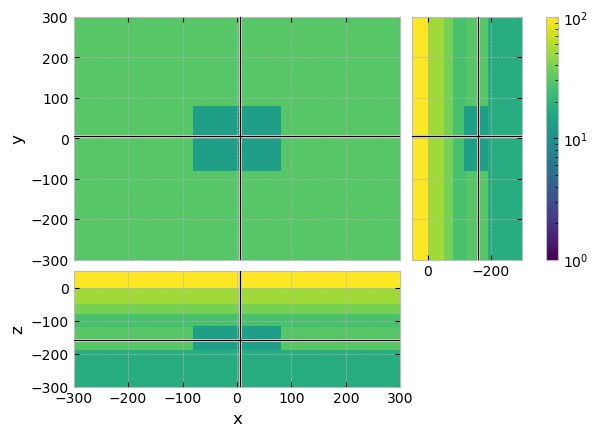

In [13]:
#QC cube location
grid.plot_3d_slicer(
    model_cube.property_x,
    pcolor_opts={'norm': LogNorm(vmin=1, vmax=100)},
    xlim=[-300, 300],
    ylim=[-300, 300],
    zlim=[-300, 50],
    zslice=-160,
)
fig = plt.gcf()

### Insert custom hot plume

In [25]:
#Load custom plume data
comsol_plume = np.loadtxt('test_plume_2.txt', skiprows=8) #data columns: radius, depth, temperature (K)
print(np.shape(comsol_plume))

#Precondition data array before interpolation, cut to size
#The custom plume should not extend beyond the cuboid area or the shape will be cropped
plume_crop = []
for i in np.arange(len(comsol_plume[:,0])):
    if comsol_plume[i,0] < cuboid_xlen and comsol_plume[i,1] > depth[4] and comsol_plume[i,1] < depth[3]:
        plume_crop.append(comsol_plume[i])

#define interpolation functions
def find_distance2d(coord1, coord2):
    distance = (coord1[0]-coord2[0])**2+(coord1[1]-coord2[1])**2
    return distance
    #This is the distance squared but it should work the same

def interpolate2d(location, array):
    dis = []
    for i in np.arange(len(array)):
        dis.append(find_distance2d(location, array[i]))
    return np.argmin(dis)

#interpolate temperature values and insert into 1d custom plume array
#To prevent edge effects, we assume that the min. temperature in the custom plume array is the original temperature of the aquifer before injection
custom = []
rho_cold = resistivities_base[4]
T_cold = min(np.array(plume_crop)[:,2])
for i in np.arange(len(cube_flat)):
    loc = grid.cell_centers[cube_flat[i]] #select a cell coordinate from our grid
    radius = np.sqrt(loc[0]**2+loc[1]**2)
    loc = np.array([radius, loc[2]]) #flatten to 2d coordinates
    T_hot = plume_crop[interpolate2d(loc, plume_crop)][2] #find temperature value of COMSOL data point closest to this cell
    res = rho_cold/(1+0.025*(T_hot-T_cold)) #translate to resistivity
    custom.append(res)

(38032, 3)
38032
[ 161.34272473 -194.56469034  300.54332162]
[ 149.58313161 -190.68351616  300.39467567]


In [26]:
#Flatten to use as indeces

print(len(custom))
print(len(cube_flat))
res4 = res3
for i in np.arange(len(cube_flat)):
    res4[cube_flat[i]]=custom[i]

model_plume = emg3d.Model(grid, property_x=res4, mapping='Resistivity')

4096
4096


# QC model and survey

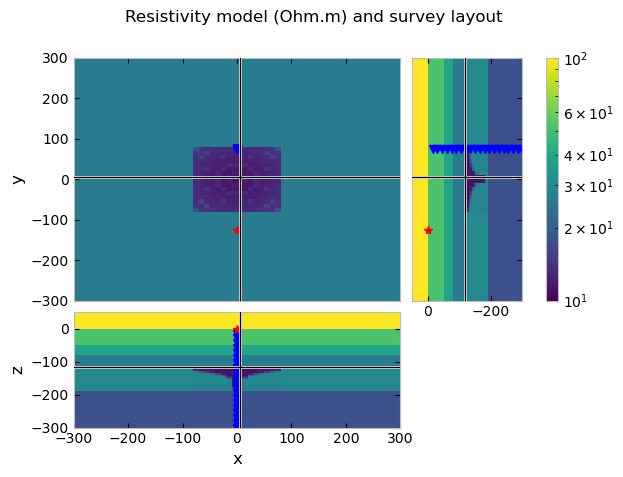

In [137]:
# QC model and survey

#'model_plume': model with custom hot plume
#'model_base': baseline layered structure
#'model_iso': uniform 25 Ohmm res. halfspace

grid.plot_3d_slicer(
    model_plume.property_x,
    pcolor_opts={'norm': LogNorm(vmin=10, vmax=100)},
    xlim=[-300, 300],
    ylim=[-300, 300],
    zlim=[-300, 50],
    zslice=-120,
)

# Plot survey in figure above
fig = plt.gcf()
fig.suptitle('Resistivity model (Ohm.m) and survey layout')
axs = fig.get_children()
rec_coords = survey.receiver_coordinates()
src_coords = survey.source_coordinates()
axs[1].plot(rec_coords[0], rec_coords[1], 'bv')
axs[2].plot(rec_coords[0], rec_coords[2], 'bv')
axs[3].plot(rec_coords[2], rec_coords[1], 'bv')
axs[1].plot(src_coords[0], src_coords[1], 'r*')
axs[2].plot(src_coords[0], src_coords[2], 'r*')
axs[3].plot(src_coords[2], src_coords[1], 'r*')
axs[1].grid(False)
axs[2].grid(False)
axs[3].grid(False)

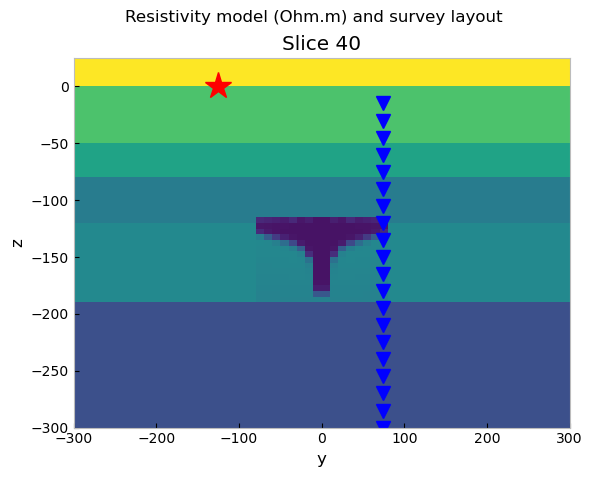

In [139]:
#Focus on the y,z plane

grid.plot_slice(
    model_plume.property_x,
    normal = 'X',
    pcolor_opts={'norm': LogNorm(vmin=10, vmax=100)},
    range_x=[-300, 300],
    range_y=[-300, 25],
#    slice_loc=0
)
fig = plt.gcf()
fig.suptitle('Resistivity model (Ohm.m) and survey layout')
axs = fig.get_children()
rec_coords = survey.receiver_coordinates()
src_coords = survey.source_coordinates()
axs[1].plot(rec_coords[1], rec_coords[2], 'bv', markersize = 10)
axs[1].plot(src_coords[1], src_coords[2], 'r*', markersize = 20)
axs[1].grid(False)

# Simulations

## Set gridding options
The grid is adapted during the running of the Simulation, the below options are passed to the Simulation to constrain these grids

In [29]:
#Generate frequency- and source-dependent grids
gopts = {
    'properties': [25, 25, 1e8],
    'min_width_limits': [10, 10, 5],
    #'stretching': (None, None, [1.0, 1.5]),
    'domain': (
        [-150, 150],
        [-300, 300],
        [-300, 0]
    ),
    'center_on_edge': False,
}

## Sensitivity of the survey to the baseline layered structure
We test if it is possible to recover the baseline layered structure using the given survey design, by calculating the misfit and sensitivity gradient against a homogeneous halfspace 25 Ohmm starting model

### Generate baseline synthetic & QC

In [30]:
#First create synthetic data of the baseline resistivity model

#Specify the survey design and noise to be added to the synthetic we create
synth_survey_base = emg3d.surveys.Survey(
    name='Survey synthetic baseline model data',  # Name of the survey
    sources=src,               # Source coordinates
    receivers=rec,             # Receiver coordinates
    frequencies=frequencies,   # Two frequencies
    # data=data,               # If you have observed data
    noise_floor=1e-15,
    relative_error=0.01,
)

#Create a simulation class which contains our survey, the resistivity model, grid, and solving parameters
synth_base_simulation = emg3d.simulations.Simulation(
        name='Simulation synthetic baseline model data',    # A name for this simulation
        survey=synth_survey_base,        # Our survey instance
        model=model_base,          # The model
        gridding='both',      # Frequency- and source-dependent meshes
        max_workers=4,        # How many parallel jobs
        # solver_opts,        # Any parameter to pass to emg3d.solve
        gridding_opts=gopts,  # Gridding options
        receiver_interpolation = "linear" #Needed for correct computation of the gradient
    )

#Compute the efield & synthetic data for the baseline model
#The version without noise is stored in the survey as 'synthetic' and version with noise as 'observed'
synth_base_simulation.compute(observed=True)

Compute efields            0/1  [00:00]

([<matplotlib.axis.XTick at 0x2e3d46d3d70>,
 [Text(1e-10, 0, '$\\mathdefault{10^{-10}}$'),
  Text(1e-09, 0, '$\\mathdefault{10^{-9}}$'),
  Text(1e-08, 0, '$\\mathdefault{10^{-8}}$'),
  Text(1e-07, 0, '$\\mathdefault{10^{-7}}$'),
  Text(1e-06, 0, '$\\mathdefault{10^{-6}}$')])

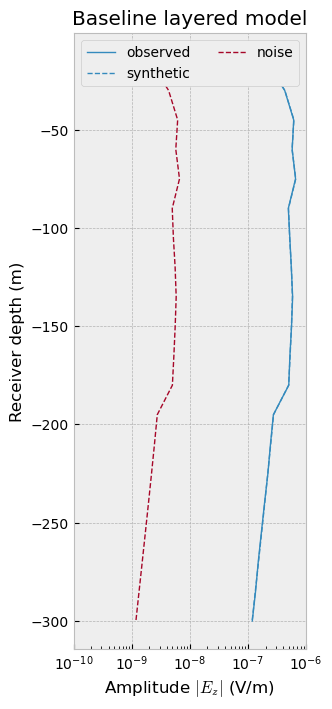

In [143]:
#QC data
plt.rcParams.update({'font.size':10})
plt.rcParams.update({'lines.linewidth':1.0})
plt.figure(figsize=(3,8))
plt.title("Baseline layered model")
obs = synth_base_simulation.data.observed[:, :, :]
syn = synth_base_simulation.data.synthetic[:, :, :]
noise = obs - syn
for i, srcn in enumerate(synth_survey_base.sources.keys()):
    for ii, freq in enumerate(synth_survey_base.frequencies):
        plt.plot(np.sqrt(obs.loc[srcn, :, freq].data.real**2 + obs.loc[srcn, :, freq].data.imag**2),
                 rec_coords[2][:],
                 label='observed' # else None
                 )
        plt.plot(np.sqrt(syn.loc[srcn, :, freq].data.real**2 + syn.loc[srcn, :, freq].data.imag**2),
                 rec_coords[2][:],
                 '--',
                 color = 'C'+str(i),
                 label = 'synthetic'
                 )
        plt.plot(np.sqrt(noise.loc[srcn, :, freq].data.real**2 +  noise.loc[srcn, :, freq].data.imag**2),
         rec_coords[2][:],
         '--',
         color = 'C'+str(i+1),
         label = 'noise'
         )
plt.xscale('log')
plt.legend(ncol=2, framealpha=1)
plt.ylabel('Receiver depth (m)')
plt.xlabel('Amplitude $|E_z|$ (V/m)')
ticks, labels = plt.xticks()
plt.xticks(ticks[1:-1])

#The relative noise dominates and has amplitude of 1% of the data

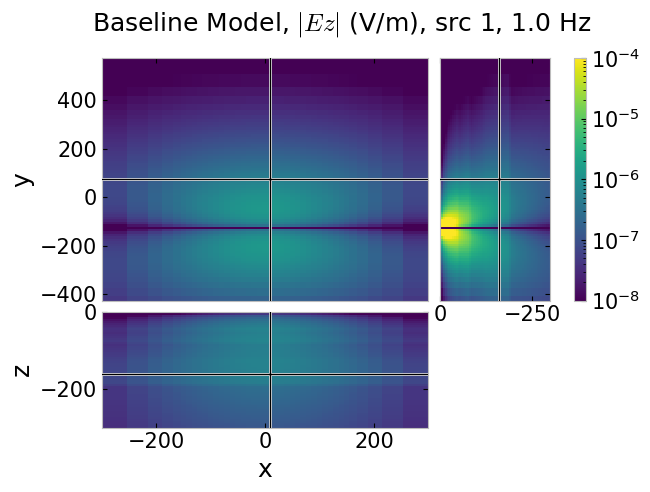

In [32]:
src_nr = 0
fr_nr = 0

#Plot the simulated electric field
newgrid = synth_base_simulation.get_grid(list(src)[src_nr], frequencies[fr_nr])
newgrid.plot_3d_slicer(
    synth_base_simulation.get_efield(list(src)[src_nr], frequencies[fr_nr]).fz.ravel('F'),
    view='abs',
    v_type='Ez',
    pcolor_opts={'norm': LogNorm(vmin=1e-8, vmax=1e-4)},
    xlim=[-300, 300],
    ylim=[-426, 574],
    zlim=[-300, 0],
    zslice=-160,
    yslice = 74
)
fig = plt.gcf()
fig.suptitle('Baseline Model, $|Ez|$ (V/m), src '+str(src_nr+1)+', '+str(frequencies[fr_nr])+' Hz')
axs = fig.get_children()
axs[1].grid(False)
axs[2].grid(False)
axs[3].grid(False)
#We see that we have a y-dipole source as we wanted, and will want to see if this source is enough to recover a layered structure of the resistivity

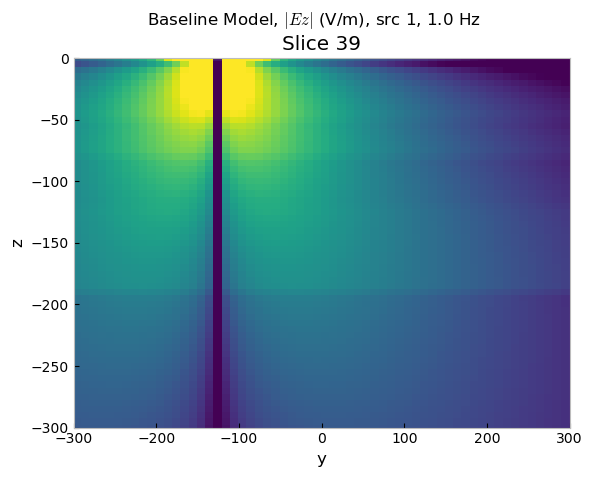

In [40]:
#Focus on the y,z plane

#Plot the simulated electric field
newgrid.plot_slice(
    synth_base_simulation.get_efield(list(src)[0], frequencies[0]).fz.ravel('F'),
    normal = 'X',
    view='abs',
    v_type='Ez',
    pcolor_opts={'norm': LogNorm(vmin=1e-8, vmax=1e-4)},
    range_x=[-300, 300],
    range_y=[-300, 0],
    slice_loc=0
)
fig = plt.gcf()
fig.suptitle('Baseline Model, $|Ez|$ (V/m), src '+str(src_nr+1)+', '+str(frequencies[fr_nr])+' Hz')
#fig.colorbar()
axs = fig.get_children()
axs[1].grid(False)

### Calculate & plot baseline gradient

In [36]:
#We now calculate the gradient using the uniform 25 Ohmm starting model, with the synthetic baseline data loaded into the survey
survey_base_forgrad = emg3d.surveys.Survey(
    name='Survey for gradient baseline model data',  # Name of the survey
    sources=src,               # Source coordinates
    receivers=rec,             # Receiver coordinates
    frequencies=frequencies,   # Two frequencies
    data=synth_base_simulation.data.observed,        # If you have observed data
    noise_floor=1e-15,
    relative_error=0.01,
)

simulation_base_forgrad = emg3d.simulations.Simulation(
        name='Simulation for gradient baseline model data',    # A name for this simulation
        survey=survey_base_forgrad,        # Our survey instance
        model=model_iso,      # The model
        gridding='both',      # Frequency- and source-dependent meshes
        max_workers=4,        # How many parallel jobs
        # solver_opts,        # Any parameter to pass to emg3d.solve
        gridding_opts=gopts,  # Gridding options
        receiver_interpolation = "linear" # Needed for correct computation of the gradient
    )
simulation_base_forgrad.compute(observed=True)
base_gradient = simulation_base_forgrad.gradient

Compute efields            0/1  [00:00]

Compute efields            0/1  [00:00]

Back-propagate            0/1  [00:00]

([<matplotlib.axis.XTick at 0x2e3bf1fb0e0>,
 [Text(1e-10, 0, '$\\mathdefault{10^{-10}}$'),
  Text(1e-09, 0, '$\\mathdefault{10^{-9}}$'),
  Text(1e-08, 0, '$\\mathdefault{10^{-8}}$'),
  Text(1e-07, 0, '$\\mathdefault{10^{-7}}$'),
  Text(1e-06, 0, '$\\mathdefault{10^{-6}}$')])

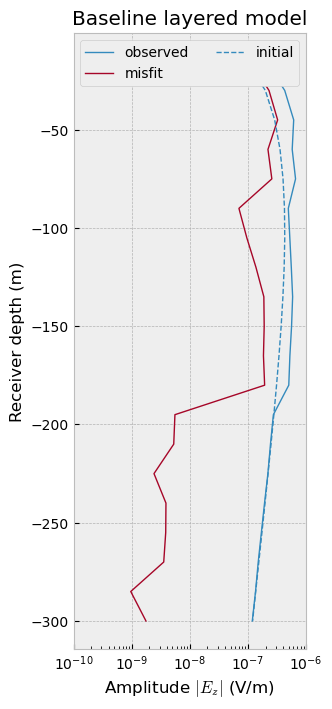

In [60]:
#QC data
plt.figure(figsize=(3,8))
plt.title("Baseline layered model")
obs = synth_base_simulation.data.observed[:, :, :] #The baseline data that should be inverted
syn = simulation_base_forgrad.data.synthetic[:, :, :] #The uniform data created by the simulation as a starting model
misfit = obs - syn #The misfit of these two
for i, srcn in enumerate(synth_survey_base.sources.keys()):
    for ii, freq in enumerate(synth_survey_base.frequencies):
        plt.plot(np.sqrt(obs.loc[srcn, :, freq].data.real**2 + obs.loc[srcn, :, freq].data.imag**2),
                 rec_coords[2][:],
                 label='observed' # else None
                 )
        plt.plot(np.sqrt(misfit.loc[srcn, :, freq].data.real**2 + misfit.loc[srcn, :, freq].data.imag**2),
                 rec_coords[2][:],
                 label='misfit' # else None
                 )
        plt.plot(np.sqrt(syn.loc[srcn, :, freq].data.real**2 + syn.loc[srcn, :, freq].data.imag**2),
                 rec_coords[2][:],
                 '--',
                 color = 'C'+str(i),
                 label = 'initial'
                 )
plt.xscale('log')
plt.legend(ncol=2, framealpha=1)
plt.ylabel('Receiver depth (m)')
plt.xlabel('Amplitude $|E_z|$ (V/m)')
ticks, labels = plt.xticks()
plt.xticks(ticks[1:-1])
#plt.locator_params(axis='x', )

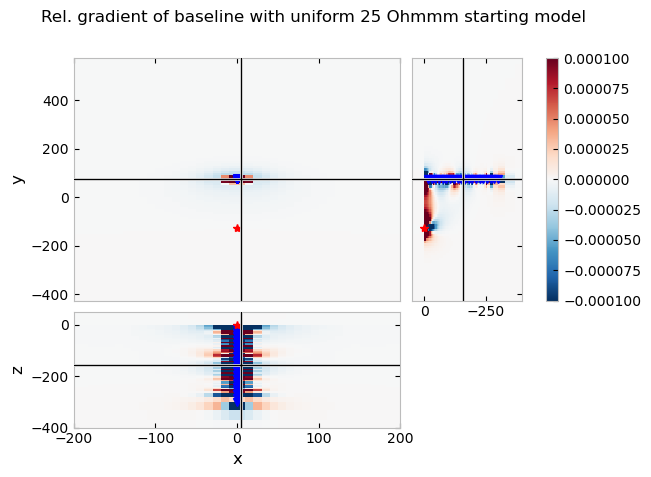

In [105]:
#Plot the gradient
#Set the gradient of air and water to NaN, this will eventually move directly into emgd3 (active and inactive cells).
#subsurface = (res < 1e3)
#grad[~subsurface] = np.nan
base_gradient_flat = base_gradient.ravel('F')
max_base_gradient = max(base_gradient_flat)
rel_base_gradient = np.divide(base_gradient_flat,max_base_gradient)

grid.plot_3d_slicer(
        rel_base_gradient,
        pcolor_opts={'cmap': 'RdBu_r',
                     'norm': Normalize(vmin=-1e-4, vmax=1e-4)},
        xlim=[-200, 200],
        ylim=[-426, 574], #center at receiver location
        zlim=[-400, 50],
        zslice=-160,
        yslice = 74)
fig = plt.gcf()
fig.suptitle('Rel. gradient of baseline with uniform 25 Ohmmm starting model')
axs = fig.get_children()
axs[1].plot(rec_coords[0], rec_coords[1], 'bv')
axs[2].plot(rec_coords[0], rec_coords[2], 'bv')
axs[3].plot(rec_coords[2], rec_coords[1], 'bv')
axs[1].plot(src_coords[0], src_coords[1], 'r*')
axs[2].plot(src_coords[0], src_coords[2], 'r*')
axs[3].plot(src_coords[2], src_coords[1], 'r*')
axs[1].grid(False)
axs[2].grid(False)
axs[3].grid(False)

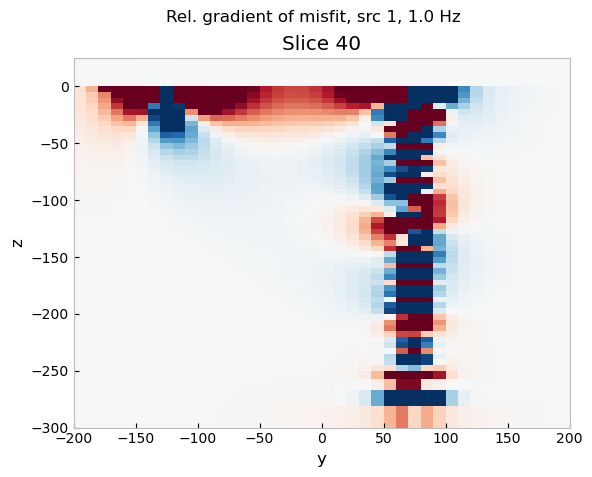

In [106]:
#Focus on the y,z plane
plt.rcParams.update({'font.size':10})
#Plot the simulated electric field
grid.plot_slice(
    rel_base_gradient,
    pcolor_opts={'cmap': 'RdBu_r',
             'norm': Normalize(vmin=-1e-4, vmax=1e-4)},
    normal = 'X',
    range_x=[-200, 200], #y extent
    range_y=[-300, 25], #z extent
    slice_loc=0 #, defaults to 0
)
fig = plt.gcf()
fig.suptitle('Rel. gradient of misfit, src '+str(src_nr+1)+', '+str(frequencies[fr_nr])+' Hz')
axs = fig.get_children()
axs[1].grid(False)
rec_coords = survey.receiver_coordinates()
src_coords = survey.source_coordinates()
#axs[1].plot(rec_coords[1], rec_coords[2], 'bv', markersize = 10)
#axs[1].plot(src_coords[1], src_coords[2], 'r*', markersize = 20)

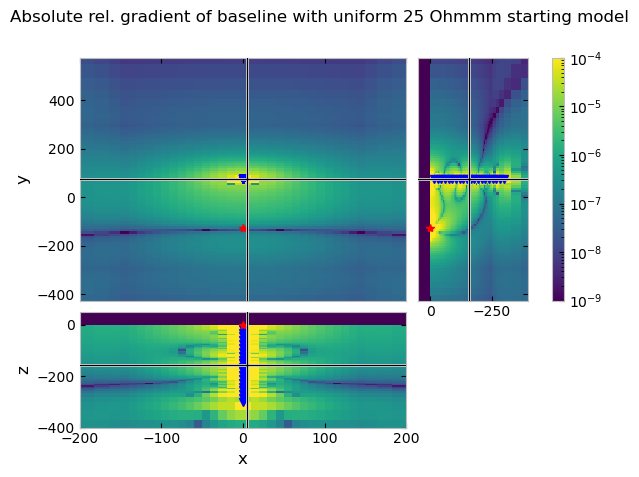

In [107]:
#Plot absolute value of the gradient
grid.plot_3d_slicer(
        np.abs(rel_base_gradient),
        pcolor_opts={'norm': LogNorm(
                         vmin=1e-9, vmax=1e-4)},
        xlim=[-200, 200],
        ylim=[-426, 574], #center at receiver location
        zlim=[-400, 50],
        zslice=-160,
        yslice = 74)
fig = plt.gcf()
fig.suptitle('Absolute rel. gradient of baseline with uniform 25 Ohmmm starting model')
axs = fig.get_children()
axs[1].plot(rec_coords[0], rec_coords[1], 'bv')
axs[2].plot(rec_coords[0], rec_coords[2], 'bv')
axs[3].plot(rec_coords[2], rec_coords[1], 'bv')
axs[1].plot(src_coords[0], src_coords[1], 'r*')
axs[2].plot(src_coords[0], src_coords[2], 'r*')
axs[3].plot(src_coords[2], src_coords[1], 'r*')
axs[1].grid(False)
axs[2].grid(False)
axs[3].grid(False)

## Sensitivity of the survey to the target hot plume
Now the baseline layered structure is taken as a starting model and the survey design is evaluated for its sensitivity to the hot plume

### Generate target model synthetic & QC

In [38]:
#Repeat the same for creating synthetic target model data
synth_survey_target = emg3d.surveys.Survey(
    name='Survey synthetic target model data',  # Name of the survey
    sources=src,               # Source coordinates
    receivers=rec,             # Receiver coordinates
    frequencies=frequencies,   # Two frequencies
    #data=data        # If you have observed data
    noise_floor=1e-15,
    relative_error=0.01,
)

synth_target_simulation = emg3d.simulations.Simulation(
        name='Simulation synthetic target model data',    # A name for this simulation
        survey=synth_survey_target,        # Our survey instance
        model=model_plume,          # The model
        gridding='both',      # Frequency- and source-dependent meshes
        max_workers=4,        # How many parallel jobs
        # solver_opts,        # Any parameter to pass to emg3d.solve
        gridding_opts=gopts,  # Gridding options
        receiver_interpolation = "linear" #Needed for correct computation of the gradient
    )
synth_target_simulation.compute(observed=True)

Compute efields            0/1  [00:00]

([<matplotlib.axis.XTick at 0x2e3d3325070>,
 [Text(1e-10, 0, '$\\mathdefault{10^{-10}}$'),
  Text(1e-09, 0, '$\\mathdefault{10^{-9}}$'),
  Text(1e-08, 0, '$\\mathdefault{10^{-8}}$'),
  Text(1e-07, 0, '$\\mathdefault{10^{-7}}$'),
  Text(1e-06, 0, '$\\mathdefault{10^{-6}}$')])

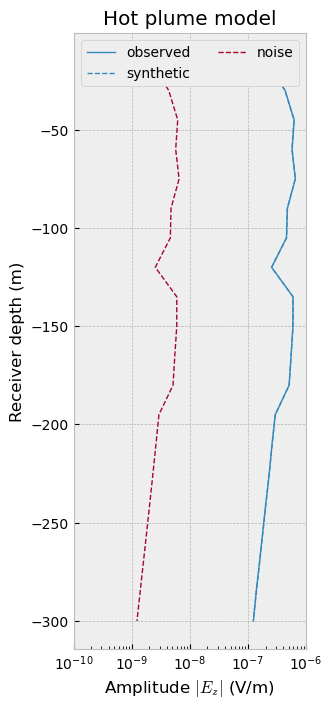

In [145]:
#QC data
plt.figure(figsize=(3,8))
plt.title("Hot plume model")
obs = synth_target_simulation.data.observed[:, :, :]
syn = synth_target_simulation.data.synthetic[:, :, :]
noise = obs - syn
for i, srcn in enumerate(synth_survey_target.sources.keys()):
    for ii, freq in enumerate(synth_survey_target.frequencies):
        plt.plot(np.sqrt(obs.loc[srcn, :, freq].data.real**2 + obs.loc[srcn, :, freq].data.imag**2),
                 rec_coords[2][:],
                 label='observed' # else None
                 )
        plt.plot(np.sqrt(syn.loc[srcn, :, freq].data.real**2 + syn.loc[srcn, :, freq].data.imag**2),
                 rec_coords[2][:],
                 '--',
                 color = 'C'+str(i),
                 label = 'synthetic'
                 )
        plt.plot(np.sqrt(noise.loc[srcn, :, freq].data.real**2 + noise.loc[srcn, :, freq].data.imag**2),
         rec_coords[2][:],
         '--',
         color = 'C'+str(i+1),
         label = 'noise'
         )
plt.xscale('log')
plt.legend(ncol=2, framealpha=1)
plt.ylabel('Receiver depth (m)')
plt.xlabel('Amplitude $|E_z|$ (V/m)')
ticks, labels = plt.xticks()
plt.xticks(ticks[1:-1])
#plt.locator_params(axis='x', )

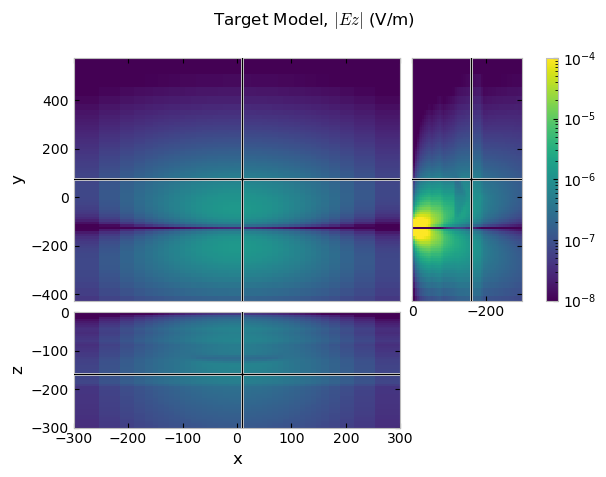

In [53]:

#Plot the simulated electric field
newgrid = synth_target_simulation.get_grid(list(src)[0], frequencies[0])
newgrid.plot_3d_slicer(
    synth_target_simulation.get_efield(list(src)[0], frequencies[0]).fz.ravel('F'),
    view='abs',
    v_type='Ez',
    pcolor_opts={'norm': LogNorm(vmin=1e-8, vmax=1e-4)},
    xlim=[-300, 300],
    ylim=[-426, 574],
    zlim=[-300, 0],
    zslice=-160,
    yslice = 74
)
fig = plt.gcf()
fig.suptitle('Target Model, $|Ez|$ (V/m)')
axs = fig.get_children()
axs[1].grid(False)
axs[2].grid(False)
axs[3].grid(False)

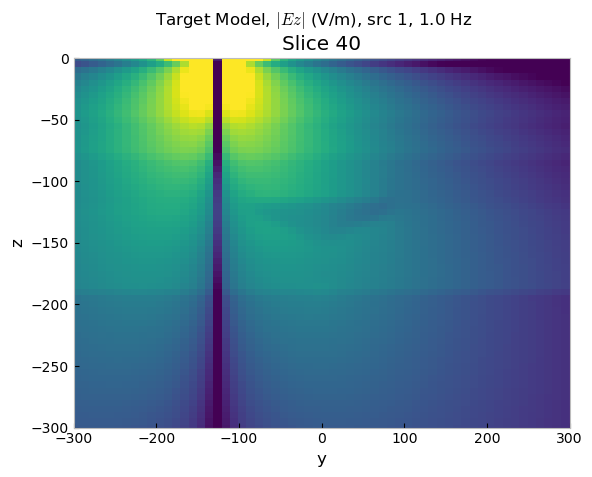

In [55]:
#Focus on the y,z plane

#Plot the simulated electric field
newgrid.plot_slice(
    synth_target_simulation.get_efield(list(src)[0], frequencies[0]).fz.ravel('F'),
    normal = 'X',
    view='abs',
    v_type='Ez',
    pcolor_opts={'norm': LogNorm(vmin=1e-8, vmax=1e-4)},
    range_x=[-300, 300], #y extent
    range_y=[-300, 0], # z extent
    #slice_loc=0, default to 0
)
fig = plt.gcf()
fig.suptitle('Target Model, $|Ez|$ (V/m), src '+str(src_nr+1)+', '+str(frequencies[fr_nr])+' Hz')
axs = fig.get_children()
axs[1].grid(False)

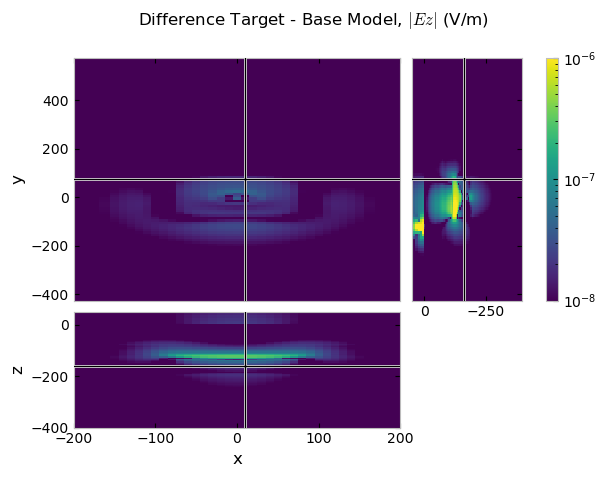

In [70]:
difference = synth_target_simulation.get_efield(list(src)[0], frequencies[0]).fz.ravel('F') - synth_base_simulation.get_efield(list(src)[0], frequencies[0]).fz.ravel('F')

#Plot the simulated electric field
#newgrid = synth_target_simulation.get_grid(list(src)[0], frequencies[0])
newgrid.plot_3d_slicer(
    difference,
    view='abs',
    v_type='Ez',
    pcolor_opts={'norm': LogNorm(vmin=1e-8, vmax=1e-6)},
    xlim=[-200, 200],
    ylim=[-426, 574], #center at receiver location
    zlim=[-400, 50],
    zslice=-160,
    yslice = 74
)
fig = plt.gcf()
fig.suptitle('Difference Target - Base Model, $|Ez|$ (V/m)')
axs = fig.get_children()
axs[1].grid(False)
axs[2].grid(False)
axs[3].grid(False)

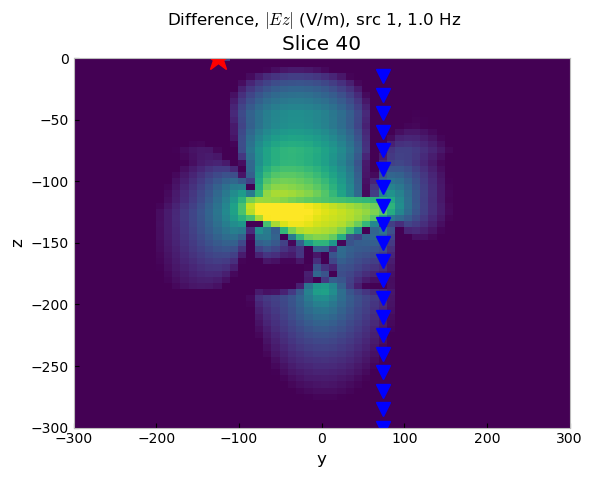

In [57]:
#Focus on the y,z plane

#Plot the simulated electric field
#newgrid = synth_target_simulation.get_grid(list(src)[0], frequencies[0])
newgrid.plot_slice(
    difference,
    normal = 'X',
    view='abs',
    v_type='Ez',
    pcolor_opts={'norm': LogNorm(vmin=1e-8, vmax=1e-6)},
    range_x=[-300, 300], #y extent
    range_y=[-300, 0], #z extent
    #slice_loc=0, default to 0
)
fig = plt.gcf()
fig.suptitle('Difference, $|Ez|$ (V/m), src '+str(src_nr+1)+', '+str(frequencies[fr_nr])+' Hz')
axs = fig.get_children()
rec_coords = survey.receiver_coordinates()
src_coords = survey.source_coordinates()
axs[1].plot(rec_coords[1], rec_coords[2], 'bv', markersize = 10)
axs[1].plot(src_coords[1], src_coords[2], 'r*', markersize = 20)
axs[1].grid(False)

### Calculate & plot target model gradient

In [58]:
#Now calculate the gradient
survey_target_forgrad = emg3d.surveys.Survey(
    name='Survey for gradient target model data',  # Name of the survey
    sources=src,               # Source coordinates
    receivers=rec,             # Receiver coordinates
    frequencies=frequencies,   # Two frequencies
    data=synth_target_simulation.data.observed ,        # If you have observed data
    noise_floor=1e-15,
    relative_error=0.01,
)

target_simulation_forgrad = emg3d.simulations.Simulation(
        name='Simulation for gradient target model data',    # A name for this simuglation
        survey=survey_target_forgrad,        # Our survey instance
        model=model_base,      # The model
        gridding='both',      # Frequency- and source-dependent meshes
        max_workers=4,        # How many parallel jobsg
        # solver_opts,        # Any parameter to pass to emg3d.solve
        gridding_opts=gopts,  # Gridding options
        receiver_interpolation = "linear" #Needed for correct computation of the gradient
    )
target_simulation_forgrad.compute(observed=True)
target_gradient = target_simulation_forgrad.gradient

Compute efields            0/1  [00:00]

Compute efields            0/1  [00:00]

Back-propagate            0/1  [00:00]

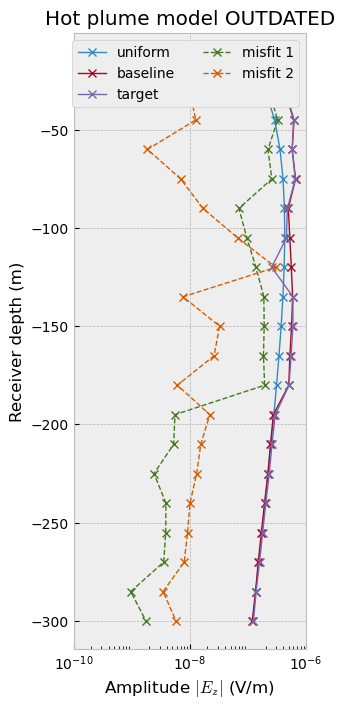

In [176]:
#OUTDATED QC OF DATA - KEEPING ONLY BECAUSE THIS WAS ON THE POSTER
plt.rcParams.update({'font.size':10})
plt.rcParams.update({'lines.linewidth':1.0})
plt.figure(figsize=(3,8))
plt.title("Hot plume model OUTDATED")
obs = synth_target_simulation.data.observed[:, :, :] # target model data to invert
syn = synth_base_simulation.data.observed[:, :, :] # baseline model data (with noise, mistake this should be without noise)
iso = simulation_base_forgrad.data.synthetic[:, :, :] #uniform res model simulation
misfit2 = obs - syn # difference target and baseline
misfit1 = syn - iso # difference target and baseline
for i, srcn in enumerate(synth_survey_base.sources.keys()):
    for ii, freq in enumerate(synth_survey_base.frequencies):
        plt.plot(np.sqrt(iso.loc[srcn, :, freq].data.real**2 + iso.loc[srcn, :, freq].data.imag**2),
                 rec_coords[2][:],
                 'x-',
                 label='uniform' # else None
                 )
        plt.plot(np.sqrt(syn.loc[srcn, :, freq].data.real**2 + syn.loc[srcn, :, freq].data.imag**2),
         rec_coords[2][:],
         '-x',
         #color = 'C'+str(i),
         label = 'baseline'
         )
        plt.plot(np.sqrt(obs.loc[srcn, :, freq].data.real**2 + obs.loc[srcn, :, freq].data.imag**2),
         rec_coords[2][:],
                 'x-',
         label='target' # else None
         )
        plt.plot(np.sqrt(misfit1.loc[srcn, :, freq].data.real**2 + misfit1.loc[srcn, :, freq].data.imag**2),
         rec_coords[2][:],
         'x--',
         label='misfit 1' # else None
         )
        plt.plot(np.sqrt(misfit2.loc[srcn, :, freq].data.real**2 + misfit2.loc[srcn, :, freq].data.imag**2),
         rec_coords[2][:],
         'x--',
         label='misfit 2' # else None
         )
plt.xscale('log')
plt.legend(ncol = 2, framealpha=1)
plt.ylabel('Receiver depth (m)')
plt.xlabel('Amplitude $|E_z|$ (V/m)')
ticks, labels = plt.xticks()
plt.xticks(ticks[1:-1:2])
#plt.locator_params(axis='x', )
plt.rcParams.update({'font.size':10})
plt.rcParams.update({'lines.linewidth':1.0})

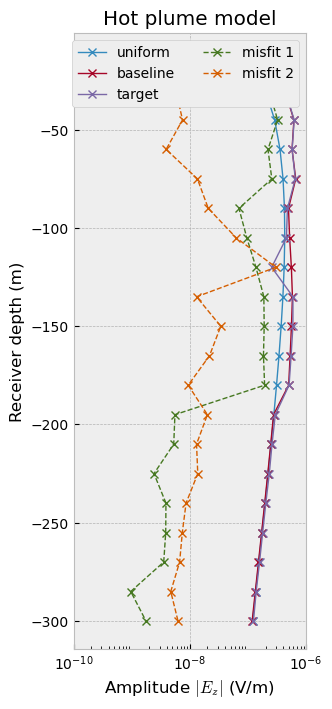

In [169]:
#QC data, NEW version
plt.rcParams.update({'font.size':10})
plt.rcParams.update({'lines.linewidth':1.0})
plt.figure(figsize=(3,8))
plt.title("Hot plume model")
obs = synth_target_simulation.data.observed[:, :, :] # target model data to invert
obs_base = synth_base_simulation.data.observed[:, :, :]
syn = synth_base_simulation.data.synthetic[:, :, :] # baseline model data (with noise, mistake this should be without noise)
iso = simulation_base_forgrad.data.synthetic[:, :, :] #uniform res model simulation
misfit2 = obs - syn # difference target and baseline
misfit1 = obs_base - iso # difference target and baseline
for i, srcn in enumerate(synth_survey_base.sources.keys()):
    for ii, freq in enumerate(synth_survey_base.frequencies):
        plt.plot(np.sqrt(iso.loc[srcn, :, freq].data.real**2 + iso.loc[srcn, :, freq].data.imag**2),
                 rec_coords[2][:],
                 'x-',
                 label='uniform' # else None
                 )
        plt.plot(np.sqrt(syn.loc[srcn, :, freq].data.real**2 + syn.loc[srcn, :, freq].data.imag**2),
         rec_coords[2][:],
         '-x',
         #color = 'C'+str(i),
         label = 'baseline'
         )
        plt.plot(np.sqrt(obs.loc[srcn, :, freq].data.real**2 + obs.loc[srcn, :, freq].data.imag**2),
         rec_coords[2][:],
                 'x-',
         label='target' # else None
         )
        plt.plot(np.sqrt(misfit1.loc[srcn, :, freq].data.real**2 + misfit1.loc[srcn, :, freq].data.imag**2),
         rec_coords[2][:],
         'x--',
         label='misfit 1' # else None
         )
        plt.plot(np.sqrt(misfit2.loc[srcn, :, freq].data.real**2 + misfit2.loc[srcn, :, freq].data.imag**2),
         rec_coords[2][:],
         'x--',
         label='misfit 2' # else None
         )
plt.xscale('log')
plt.legend(ncol = 2, framealpha=1)
plt.ylabel('Receiver depth (m)')
plt.xlabel('Amplitude $|E_z|$ (V/m)')
ticks, labels = plt.xticks()
plt.xticks(ticks[1:-1:2])
#plt.locator_params(axis='x', )
plt.rcParams.update({'font.size':10})
plt.rcParams.update({'lines.linewidth':1.0})

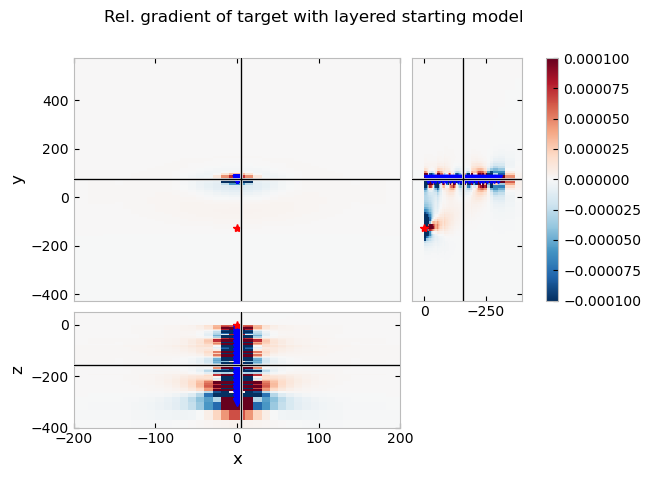

In [109]:
#Plot the gradient
#Set the gradient of air and water to NaN, this will eventually move directly into emgd3 (active and inactive cells).
#subsurface = (res < 1e3)
#grad[~subsurface] = np.nan
target_gradient_flat = target_gradient.ravel('F')
max_target_gradient = max(target_gradient_flat)
rel_target_gradient = np.divide(target_gradient_flat,max_target_gradient)

grid.plot_3d_slicer(
        rel_target_gradient,
        pcolor_opts={'cmap': 'RdBu_r',
                     'norm': Normalize(vmin=-1e-4, vmax=1e-4)},
        xlim=[-200, 200],
        ylim=[-426, 574], #center at receiver location
        zlim=[-400, 50],
        zslice=-160,
        yslice = 74)
fig = plt.gcf()
fig.suptitle('Rel. gradient of target with layered starting model')
axs = fig.get_children()
axs[1].plot(rec_coords[0], rec_coords[1], 'bv')
axs[2].plot(rec_coords[0], rec_coords[2], 'bv')
axs[3].plot(rec_coords[2], rec_coords[1], 'bv')
axs[1].plot(src_coords[0], src_coords[1], 'r*')
axs[2].plot(src_coords[0], src_coords[2], 'r*')
axs[3].plot(src_coords[2], src_coords[1], 'r*')
axs[1].grid(False)
axs[2].grid(False)
axs[3].grid(False)

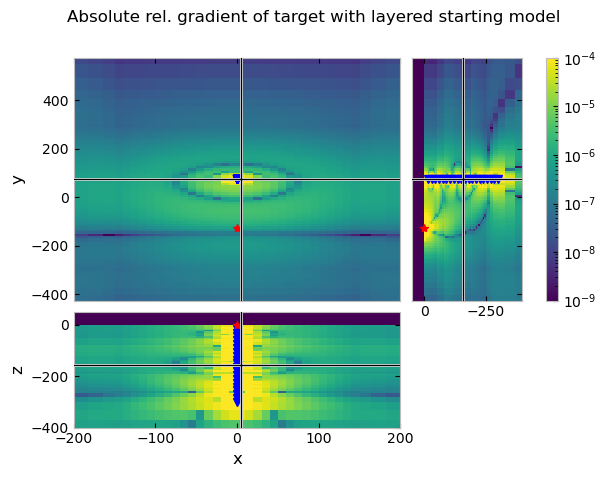

In [76]:
grid.plot_3d_slicer(
        np.abs(rel_target_gradient),
        pcolor_opts={'norm': LogNorm(
                         vmin=1e-9, vmax=1e-4)},
        xlim=[-200, 200],
        ylim=[-426, 574], #center at receiver location
        zlim=[-400, 50],
        zslice=-160,
        yslice = 74)
fig = plt.gcf()
fig.suptitle('Absolute rel. gradient of target with layered starting model')
axs = fig.get_children()
axs[1].plot(rec_coords[0], rec_coords[1], 'bv')
axs[2].plot(rec_coords[0], rec_coords[2], 'bv')
axs[3].plot(rec_coords[2], rec_coords[1], 'bv')
axs[1].plot(src_coords[0], src_coords[1], 'r*')
axs[2].plot(src_coords[0], src_coords[2], 'r*')
axs[3].plot(src_coords[2], src_coords[1], 'r*')
axs[1].grid(False)
axs[2].grid(False)
axs[3].grid(False)

In [ ]:
print(np.size(rel_target_gradient))
print(np.shape(rel_target_gradient))

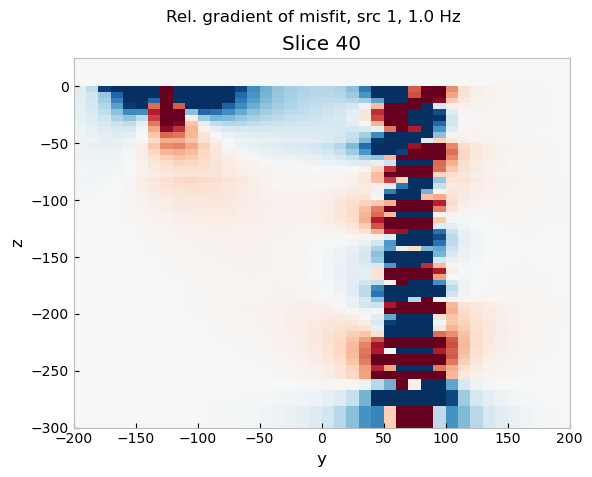

In [108]:
#Focus on the y,z plane
plt.rcParams.update({'font.size':10})
#Plot the simulated electric field
newgrid = synth_target_simulation.get_grid(list(src)[0], frequencies[0])
grid.plot_slice(
    rel_target_gradient,
    pcolor_opts={'cmap': 'RdBu_r',
             'norm': Normalize(vmin=-1e-4, vmax=1e-4)},
    normal = 'X',
    range_x=[-200, 200], #y extent
    range_y=[-300, 25], #z extent
    #slice_loc=0, default to 0
)
fig = plt.gcf()
fig.suptitle('Rel. gradient of misfit, src '+str(src_nr+1)+', '+str(frequencies[fr_nr])+' Hz')
axs = fig.get_children()
axs[1].grid(False)

[3.01273175e-45 5.32382193e-45 1.27568723e-44 2.92180324e-44
 5.53162408e-44 1.06441703e-43 2.08954590e-43 1.73503407e-43
 9.83254085e-45 7.07952713e-44]
[2.40217598e-23 2.72866054e-23 3.18176766e-23 3.36817988e-23
 3.34612901e-23 3.25143730e-23 3.20672521e-23 3.32171637e-23
 3.01737459e-23 1.72821967e-23]
[-3.08665973e-23 -4.56779198e-23 -8.11286481e-23 -1.37251031e-22
 -2.01732759e-22 -2.93739674e-22 -4.25048258e-22 -3.83320238e-22
 -6.89854233e-23  2.83356005e-22]


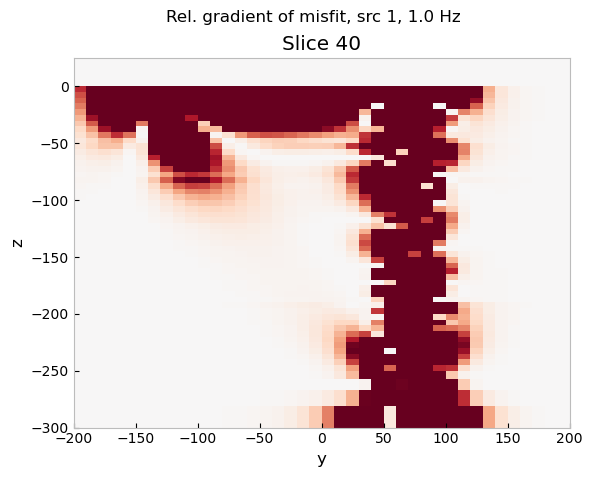

In [130]:
difference_of_gradients = (rel_target_gradient-rel_base_gradient)**2

print(difference_of_gradients[10000:10010])
print(rel_target_gradient[10000:10010])
print(rel_base_gradient[10000:10010])
#Focus on the y,z plane
plt.rcParams.update({'font.size':10})
#Plot the simulated electric field
#newgrid = synth_target_simulation.get_grid(list(src)[0], frequencies[0])
grid.plot_slice(
    difference_of_gradients,
    pcolor_opts={'cmap': 'RdBu_r',
             'norm': Normalize(vmin=-1e-9, vmax=1e-9)},
    normal = 'X',
    range_x=[-200, 200], #y extent
    range_y=[-300, 25], #z extent
    #slice_loc=0, default to 0
)
fig = plt.gcf()
fig.suptitle('Rel. gradient of misfit, src '+str(src_nr+1)+', '+str(frequencies[fr_nr])+' Hz')
axs = fig.get_children()
axs[1].grid(False)

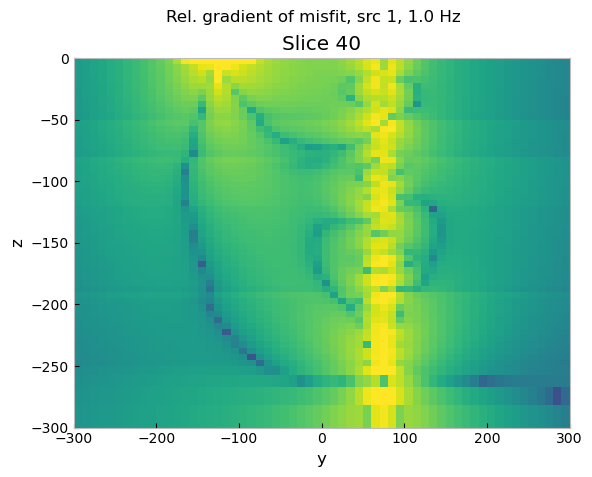

In [79]:
#Focus on the y,z plane

#Plot the simulated electric field
#newgrid = synth_target_simulation.get_grid(list(src)[0], frequencies[0])
grid.plot_slice(
    abs(rel_target_gradient),
    pcolor_opts={'norm': LogNorm(
                     vmin=1e-11, vmax=1e-3)},
    normal = 'X',
    range_x=[-300, 300], #y extent
    range_y=[-300, 0], #z extent
    #slice_loc=0, default to 0
)
fig = plt.gcf()
fig.suptitle('Rel. gradient of misfit, src '+str(src_nr+1)+', '+str(frequencies[fr_nr])+' Hz')
axs = fig.get_children()
axs[1].grid(False)

## Test noise-only gradient
Due to the similarity of the gradients of the baseline against uniform and target against baseline simulations, I here tested the sensitivity gradient of the baseline with noise against the baseline without noise. This gradient looks similar to both, showing that the gradient is more sensitive to the noise in the data than the features we are interested to investigate.

### Calculate & plot noise-only gradient

In [148]:
survey_test_forgrad = emg3d.surveys.Survey(
    name='Survey for gradient test',  # Name of the survey
    sources=src,               # Source coordinates
    receivers=rec,             # Receiver coordinates
    frequencies=frequencies,   # Two frequencies
    data=synth_base_simulation.data.observed ,        # If you have observed data
    noise_floor=1e-15,
    relative_error=0.01,
)

test_simulation_forgrad = emg3d.simulations.Simulation(
        name='Simulation for gradient test',    # A name for this simuglation
        survey=survey_test_forgrad,        # Our survey instance
        model=model_base,      # The model
        gridding='both',      # Frequency- and source-dependent meshes
        max_workers=4,        # How many parallel jobsg
        # solver_opts,        # Any parameter to pass to emg3d.solve
        gridding_opts=gopts,  # Gridding options
        receiver_interpolation = "linear" #Needed for correct computation of the gradient
    )
test_simulation_forgrad.compute(observed=True)
test_gradient = test_simulation_forgrad.gradient

Compute efields            0/1  [00:00]

Compute efields            0/1  [00:00]

Back-propagate            0/1  [00:00]

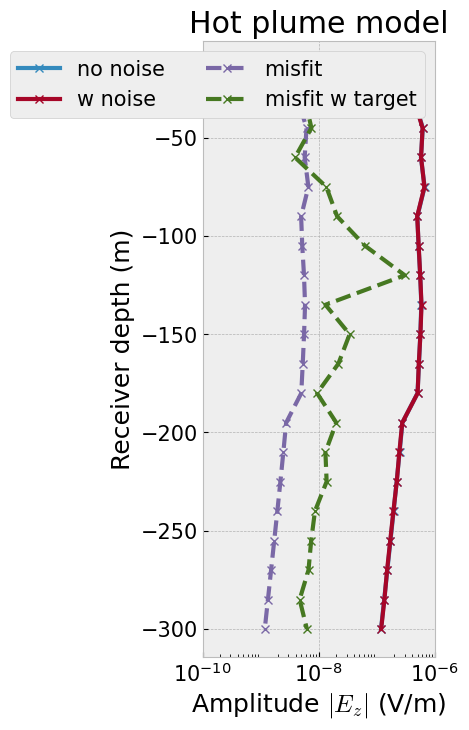

In [170]:
#QC data
plt.rcParams.update({'font.size':15})
plt.rcParams.update({'lines.linewidth':3.0})
plt.figure(figsize=(3,8))
plt.title("Hot plume model")
obs = synth_base_simulation.data.observed[:, :, :]
syn = synth_base_simulation.data.synthetic[:, :, :]
misfit = obs - syn
for i, srcn in enumerate(synth_survey_base.sources.keys()):
    for ii, freq in enumerate(synth_survey_base.frequencies):
        plt.plot(np.sqrt(syn.loc[srcn, :, freq].data.real**2 + syn.loc[srcn, :, freq].data.imag**2),
         rec_coords[2][:],
         '-x',
         #color = 'C'+str(i),
         label = 'no noise'
         )
        plt.plot(np.sqrt(obs.loc[srcn, :, freq].data.real**2 + obs.loc[srcn, :, freq].data.imag**2),
         rec_coords[2][:],
                 'x-',
         label='w noise' # else None
         )
        plt.plot(np.sqrt(misfit.loc[srcn, :, freq].data.real**2 + misfit.loc[srcn, :, freq].data.imag**2),
         rec_coords[2][:],
         'x--',
         label='misfit' # else None
         )
        plt.plot(np.sqrt(misfit2.loc[srcn, :, freq].data.real**2 + misfit2.loc[srcn, :, freq].data.imag**2),
         rec_coords[2][:],
         'x--',
         label='misfit w target' # else None
         )
plt.xscale('log')
plt.legend(ncol = 2, framealpha=1)
plt.ylabel('Receiver depth (m)')
plt.xlabel('Amplitude $|E_z|$ (V/m)')
ticks, labels = plt.xticks()
plt.xticks(ticks[1:-1:2])
#plt.locator_params(axis='x', )
plt.rcParams.update({'font.size':10})
plt.rcParams.update({'lines.linewidth':1.0})
#The relative noise clearly dominates the noise pattern, as the noise floor is very low, so the noise is just proportional to the data
#What about if we plot the misfit that isn't absolute?

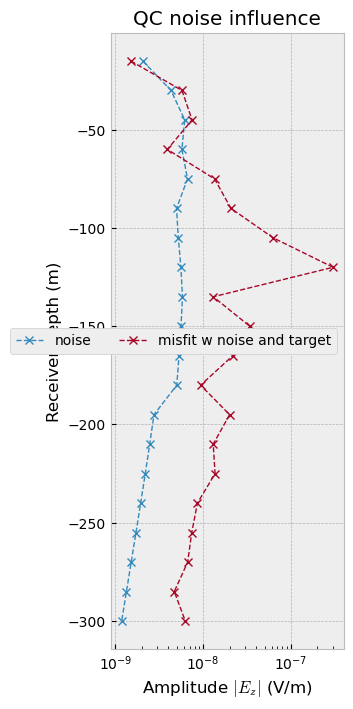

In [174]:
#QC data
plt.rcParams.update({'font.size':10})
plt.rcParams.update({'lines.linewidth':1.0})
plt.figure(figsize=(3,8))
plt.title("QC noise influence")
norm_misfit = misfit2/misfit
for i, srcn in enumerate(synth_survey_base.sources.keys()):
    for ii, freq in enumerate(synth_survey_base.frequencies):
        plt.plot(np.sqrt(misfit.loc[srcn, :, freq].data.real**2 + misfit.loc[srcn, :, freq].data.imag**2),
         rec_coords[2][:],
        'x--',
         label='noise' # else None
         )
        plt.plot(np.sqrt(misfit2.loc[srcn, :, freq].data.real**2 + misfit2.loc[srcn, :, freq].data.imag**2),
         rec_coords[2][:],
                 'x--',
         label='misfit w noise and target' # else None
         )
        #plt.plot(np.sqrt(norm_misfit.loc[srcn, :, freq].data.real**2 + norm_misfit.loc[srcn, :, freq].data.imag**2),
        # rec_coords[2][:],
        #'x--',
        # label='normalized misfit to noise' # else None
        # )
plt.xscale('log')
plt.legend(ncol = 2, framealpha=1)
plt.ylabel('Receiver depth (m)')
plt.xlabel('Amplitude $|E_z|$ (V/m)')
#ticks, labels = plt.xticks()
#plt.xticks(ticks[1:-1:2])
#plt.locator_params(axis='x', )
plt.rcParams.update({'font.size':10})
plt.rcParams.update({'lines.linewidth':1.0})
#The relative noise clearly dominates the noise pattern, as the noise floor is very low, so the noise is just proportional to the data
#What about if we plot the misfit that isn't absolute?

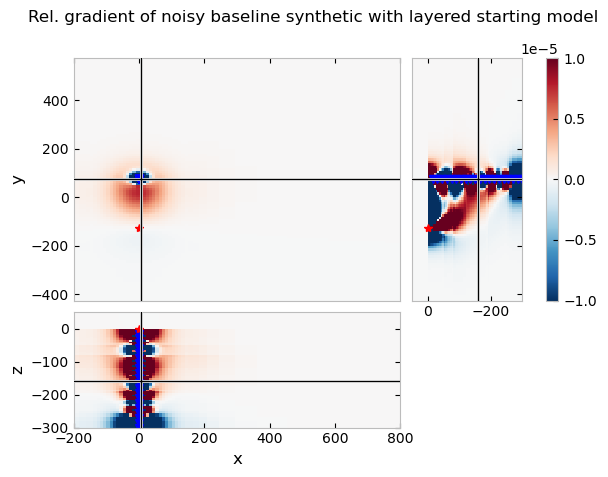

In [151]:
test_gradient_flat = test_gradient.ravel('F')
max_gradient = max(test_gradient_flat)
rel_test_gradient = np.divide(test_gradient_flat,max_gradient)

grid.plot_3d_slicer(
        rel_test_gradient,
        pcolor_opts={'cmap': 'RdBu_r',
                     'norm': Normalize(vmin=-1e-5, vmax=1e-5)},
        xlim=[-200, 800],
        ylim=[-426, 574],
        zlim=[-300, 50],
        zslice=-160,
        yslice = 74)
fig = plt.gcf()
fig.suptitle('Rel. gradient of noisy baseline synthetic with layered starting model')
axs = fig.get_children()
axs[1].plot(rec_coords[0], rec_coords[1], 'bv')
axs[2].plot(rec_coords[0], rec_coords[2], 'bv')
axs[3].plot(rec_coords[2], rec_coords[1], 'bv')
axs[1].plot(src_coords[0], src_coords[1], 'r*')
axs[2].plot(src_coords[0], src_coords[2], 'r*')
axs[3].plot(src_coords[2], src_coords[1], 'r*')
axs[1].grid(False)
axs[2].grid(False)
axs[3].grid(False)
#The gradient looks the same as for the baseline model, since we are only looking at the relative noise added to the data

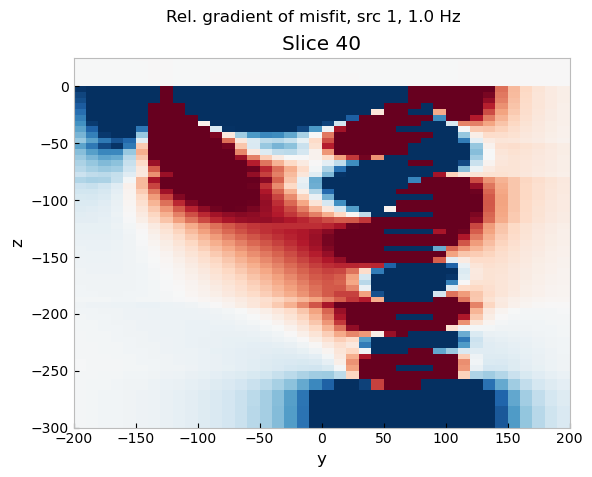

In [153]:
#Focus on the y,z plane
plt.rcParams.update({'font.size':10})
#Plot the simulated electric field
#newgrid = synth_target_simulation.get_grid(list(src)[0], frequencies[0])
grid.plot_slice(
    rel_test_gradient,
    pcolor_opts={'cmap': 'RdBu_r',
             'norm': Normalize(vmin=-1e-5, vmax=1e-5)},
    normal = 'X',
    range_x=[-200, 200], #y extent
    range_y=[-300, 25], #z extent
    #slice_loc=0, default to 0
)
fig = plt.gcf()
fig.suptitle('Rel. gradient of misfit, src '+str(src_nr+1)+', '+str(frequencies[fr_nr])+' Hz')
axs = fig.get_children()
axs[1].grid(False)